In [8]:
#libreria para manejo de NDARRAY
import numpy as np;
import scipy as sp
#libreria para graficar
#tipo matlab: pyplot
#objetual: figure, axes
import matplotlib.pyplot as plt
from csv import reader as reader_csv;
import scipy.signal as signal;
import spacy
import scipy.io as sio
import scipy.stats as stats
from sympy import symbols
import os
import sympy as sym
import pandas as pd
from statsmodels.stats.diagnostic import lilliefors
from scipy.stats import mannwhitneyu
from scipy.stats import levene
import pingouin as pg

In [9]:

ruta_carpeta = './control'

# Obtener la lista de archivos en la carpeta
lista_archivos = os.listdir(ruta_carpeta)

# Crear una matriz vacía para almacenar los datos
datos_matriz = [] # num_columnas es el número de columnas en los datos

# Iterar a través de cada archivo y agregar los datos a la matriz
for archivo in lista_archivos:
    # Verificar que el archivo sea de tipo .mat
    if archivo.endswith('.mat'):
        # Cargar los datos del archivo
        mat_contents = sio.loadmat(os.path.join(ruta_carpeta, archivo))
        data = mat_contents['data']
        senal_continua = np.reshape(data,(data.shape[0],data.shape[1]*data.shape[2]),order='F')
        # Agregar los datos a la matriz
        datos_matriz.append(data)

ruta_carpeta = './parkinson'
lista_archivos = os.listdir(ruta_carpeta)
datos_parkinson=[]
for archivo in lista_archivos:
    # Verificar que el archivo sea de tipo .mat
    if archivo.endswith('.mat'):
        # Cargar los datos del archivo
        mat_contents = sio.loadmat(os.path.join(ruta_carpeta, archivo))
        data = mat_contents['data']
        senal_continua = np.reshape(data,(data.shape[0],data.shape[1]*data.shape[2]),order='F')
        # Agregar los datos a la matriz
        datos_parkinson.append(data)
print("Todo cargado")

Todo cargado


In [3]:
def ecu_spectraldensity(xn,nl,N):
    sums_sk=[]
    w_n=0.42-0.5*np.cos((2*np.pi*nl)/(N-1))
    xn=w_n*xn
    for k in nl:
        s_k=np.abs(np.sum(xn*np.exp((-1j*2*np.pi*k*nl)/N)))**2
        sums_sk.append(s_k)
    return np.array(sums_sk)/N

In [4]:
def spectraldensity(xn,epoca=119,paciente=0):
    xn=xn[paciente]
    xn=xn[:,:,epoca]
    sums_k_list=[]
    for canal in xn:
        N=len(canal)
        nl=np.arange(N)
        s_k=ecu_spectraldensity(canal,nl,N)
        sums_k_list.append(s_k)
    return sums_k_list

In [5]:
x=spectraldensity(datos_matriz,119,0)


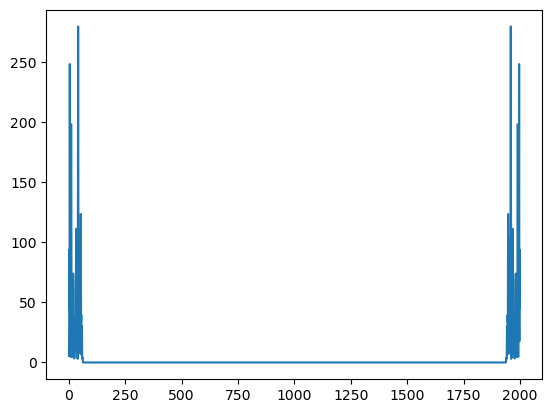

In [6]:
plt.plot(x[0])

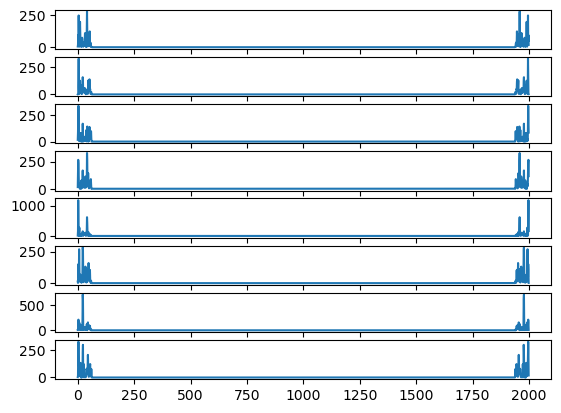

In [7]:
for i in range(len(x)):
    plt.subplot(8,1,i+1)
    plt.plot(x[i])
plt.show()

# 2 
Crear una función que reciba una señal EEG de múltiples épocas, un canal, y devuelva la sumatoria de densidad espectral de potencia, para el rango de frecuencia de 13 a 30 Hz, del promedio de la densidad espectral de potencia de las diferentes épocas de la señal de análisis

In [9]:
def sum_spectraldensity(data,canal=0,paciente=0,fs=1000,fini=13,ffin=30):
    data=data[paciente][canal,:,:]
    puntos=[]
    for punto in data:
        p=np.mean(punto)
        puntos.append(p)
    z=np.array(puntos)
    N=len(z)
    nl=np.arange(N)
    s_k=ecu_spectraldensity(z,nl,N)
    frecuencia=np.linspace(0,fs,num=N)
    return s_k,frecuencia

In [10]:
def sum_spectraldensity(data,canal=0,paciente=0,fs=1000,fini=13,ffin=30):
    data=data[paciente][canal,:,:]
    z=np.mean(data,axis=1)
    N=len(z)
    nl=np.arange(N)
    s_k=ecu_spectraldensity(z,nl,N)
    frecuencia=np.linspace(0,fs,num=N)
    return s_k,frecuencia

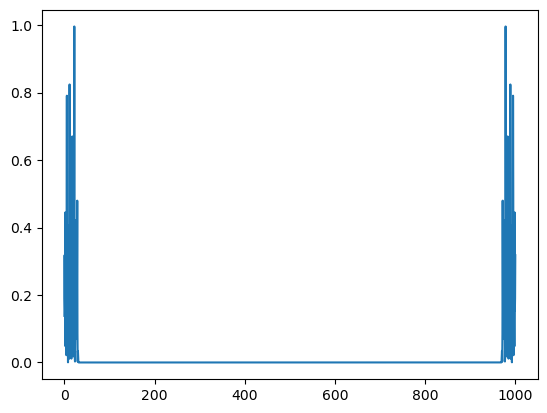

In [11]:
x,f=sum_spectraldensity(datos_matriz,0,0)
plt.plot(f,x)


In [12]:
def spectralrange(x,f,ini=13,end=30):
    bf=np.where((f>=13) &(f<=30))
    f=f[bf]
    x=x[bf]
    return f,x

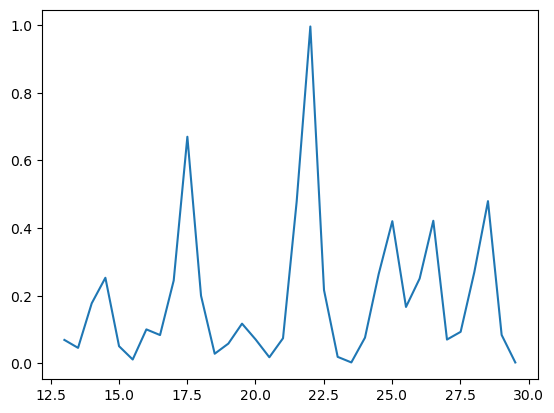

In [13]:
f,x=spectralrange(x,f,13,30)
plt.plot(f,x)

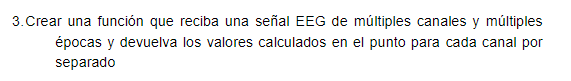

In [14]:
def PSD(data,paciente=0):
    sums_k_list=[]
    canales=np.arange(len(data[paciente][:,0,0]))
    for canal in canales:
        s_k,f=sum_spectraldensity(data,canal,paciente)
        f,x=spectralrange(s_k,f)
        s_k=np.sum(x)
        sums_k_list.append(s_k)
    return sums_k_list

In [15]:
X=PSD(datos_matriz)

In [16]:
print(X)

[6.588136262156796, 7.170274084597011, 8.488089358209756, 6.342503451805725, 6.311502654693775, 8.79407395065854, 7.26157308045821, 11.369824100507422]


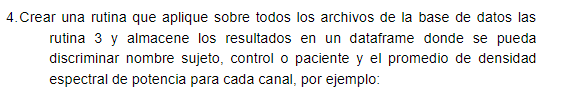

In [17]:
datosprompaciente=[]
r=np.arange(len(datos_matriz))
for i in r:
    promcanales=["Control"]
    x=PSD(datos_matriz,i)
    for canal in x:
        promcanales.append(canal)
    datosprompaciente.append(promcanales)

datosprompaciente_p=[]
r=np.arange(len(datos_parkinson))
for i in r:
    promcanales=["Parkinson"]
    x=PSD(datos_parkinson,i)
    for canal in x:
        promcanales.append(canal)
    datosprompaciente_p.append(promcanales)

In [18]:
names = ["Estado",'PSD_C3', 'PSD_C1', 'PSD_CZ', 'PSD_C2', 'PSD_C4', 'PSD_O1', 'PSD_OZ', 'PSD_O2'] #Los nombres de las columnas
df=pd.DataFrame(columns=names) #Se crea el data frame
con=1 
for paciente in datosprompaciente: #Se inspecciona cada paciente, en este caso pandas toma las listas así que solo se coloca paciente (lista con primedio de cada canal) y el contador para identificar el paciente
    df.loc[con]=paciente
    con+=1
for paciente in datosprompaciente_p:
    df.loc[con]=paciente
    con+=1
df.index.name="Sujeto"
df

,Estado,PSD_C3,PSD_C1,PSD_CZ,PSD_C2,PSD_C4,PSD_O1,PSD_OZ,PSD_O2
Sujeto,,,,,,,,,
1,Control,6.588136,7.170274,8.488089,6.342503,6.311503,8.794074,7.261573,11.369824
2,Control,6.937180,4.682711,2.739435,2.267806,4.730358,13.290693,11.449452,12.883728
3,Control,4.018534,3.599051,5.457592,2.222556,5.556907,2.553184,2.944823,4.609807
4,Control,9.762080,6.623699,9.884979,11.724950,14.610523,22.633438,15.156428,12.204539
5,Control,5.309109,6.728339,8.453612,8.823974,8.370769,10.319439,9.530214,9.589701
6,Control,6.184479,5.465086,4.825497,3.054241,3.661056,4.980654,5.412684,6.552773
7,Control,4.139802,2.935076,3.841803,4.263166,5.032301,7.541838,6.499612,9.207845
8,Control,3.629768,2.767345,2.806591,2.857862,5.790350,6.864858,6.927915,9.292365
9,Control,1.926986,2.042166,2.071883,1.542974,1.392093,12.023476,8.962724,8.070981


In [19]:
df.to_csv("Tabla.cvs",index=False)

In [106]:
df=pd.read_csv("Tabla.cvs")

# Filtrado

In [169]:
df=df.drop(np.where(np.logical_and( df["Estado"]=="Control",df[df.columns[8]]>30).values)[0])
df=df.reset_index(drop=True)
df=df.drop(np.where(np.logical_and( df["Estado"]=="Control",df[df.columns[7]]>25).values)[0])
df=df.reset_index(drop=True)
df=df.drop(np.where(np.logical_and( df["Estado"]=="Control",df[df.columns[6]]>30).values)[0])
df=df.reset_index(drop=True)
df=df.drop(np.where(np.logical_and( df["Estado"]=="Control",df[df.columns[5]]>20).values)[0])
df=df.reset_index(drop=True)


In [171]:
df=df.drop(np.where(np.logical_and( df["Estado"]=="Parkinson",df[df.columns[8]]>40).values)[0])
df=df.reset_index(drop=True)
df=df.drop(np.where(np.logical_and( df["Estado"]=="Parkinson",df[df.columns[6]]>26).values)[0])
df=df.reset_index(drop=True)


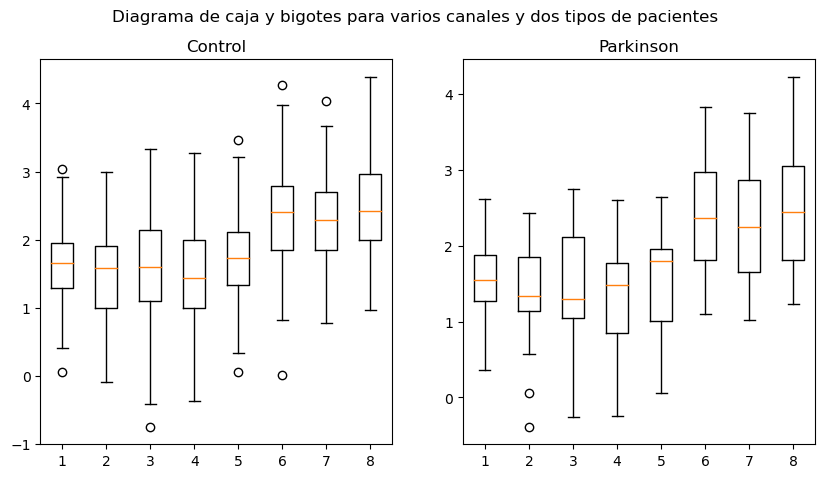

In [89]:
# Crear una lista de dataframes, uno por cada estado
dataframes = [df[df['Estado']=='Control'], df[df['Estado']=='Parkinson']]

# Crear una lista de nombres para las etiquetas del gráfico
labels = ['Control', 'Parkinson']

# Crear una figura y dos subplots (uno por cada estado)
fig, axs = plt.subplots(1, 2, figsize=(10,5))

# Para cada estado y subplot, hacer un diagrama de caja y bigotes para cada canal
for i, df_estado in enumerate(dataframes):
    axs[i].boxplot([df_estado['PSD_C3'], df_estado['PSD_C1'], df_estado['PSD_CZ'], df_estado['PSD_C2'], df_estado['PSD_C4'], df_estado['PSD_O1'], df_estado['PSD_OZ'], df_estado['PSD_O2']])
    axs[i].set_title(labels[i])
fig.suptitle('Diagrama de caja y bigotes para varios canales y dos tipos de pacientes')
plt.show()

In [135]:
df.to_csv("Datos_filtrados.cvs",index=False)

In [105]:
df=pd.read_csv("Datos_filtrados.cvs")

# Normalizacion

In [107]:
df2=df.copy()
data=np.log(df2.iloc[:,1:9])
data=data.join(pd.DataFrame(df2.iloc[:,0].values,columns=["Estado"]))
a=list(data.columns)
a[0],a[8]=a[8],a[0]
data=data[a]

In [108]:
df=data

In [109]:
df.to_csv("Datos_Normalizados.cvs",index=False)

In [110]:
df=pd.read_csv("Datos_Normalizados.cvs")

In [113]:
df=df.drop(np.where(np.logical_and( df["Estado"]=="Parkinson",df[df.columns[2]]<0).values)[0])
df=df.reset_index(drop=True)

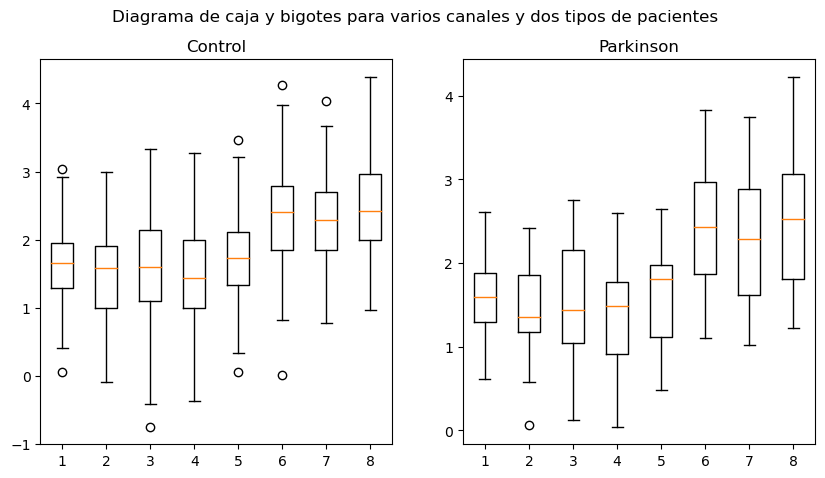

In [114]:
# Crear una lista de dataframes, uno por cada estado
dataframes = [df[df['Estado']=='Control'], df[df['Estado']=='Parkinson']]

# Crear una lista de nombres para las etiquetas del gráfico
labels = ['Control', 'Parkinson']

# Crear una figura y dos subplots (uno por cada estado)
fig, axs = plt.subplots(1, 2, figsize=(10,5))

# Para cada estado y subplot, hacer un diagrama de caja y bigotes para cada canal
for i, df_estado in enumerate(dataframes):
    axs[i].boxplot([df_estado['PSD_C3'], df_estado['PSD_C1'], df_estado['PSD_CZ'], df_estado['PSD_C2'], df_estado['PSD_C4'], df_estado['PSD_O1'], df_estado['PSD_OZ'], df_estado['PSD_O2']])
    axs[i].set_title(labels[i])
fig.suptitle('Diagrama de caja y bigotes para varios canales y dos tipos de pacientes')
plt.show()

In [115]:
def check_normality(data):
    '''Check if the distribution is normal.'''
    
    # --- >>> START stats <<< ---
    # Graphical test: if the data lie on a line, they are pretty much
    # normally distributed
    _ = stats.probplot(data, plot=plt)
    plt.show()

    pVals = pd.Series('p-value')
    # The scipy normaltest is based on D-Agostino and Pearsons test that
    # combines skew and kurtosis to produce an omnibus test of normality.
    _, pVals['Omnibus']    = stats.normaltest(data)

    # Shapiro-Wilk test
    _, pVals['Shapiro-Wilk']    = stats.shapiro(data)
    
    print('--------------------------------')
    print('p-values for all {0} data points:'.format(len(data)))
    print(pVals)
    print('--------------------------------')
    
    if pVals['Omnibus'] > 0.05:
        print('Data are normally distributed')
    elif pVals['Shapiro-Wilk'] > 0.05:
        print('Data are normally distributed')
    else:
        print("Data arent normally distribuited")
    # --- >>> STOP stats <<< ---
    print('--------------------------------')
    
    return [pVals['Shapiro-Wilk'],pVals['Omnibus']]

For chanel: PSD_C1


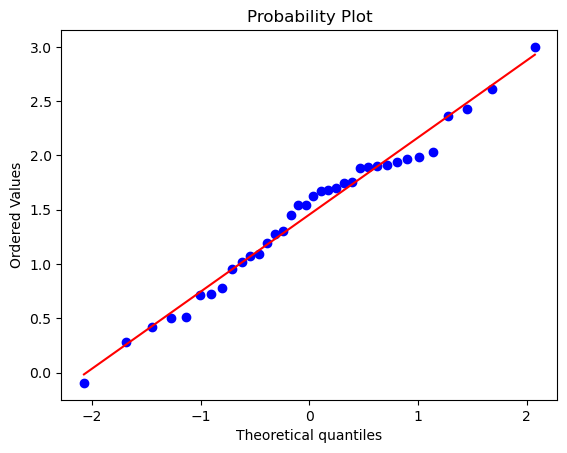

--------------------------------
p-values for all 36 data points:
0                p-value
Omnibus         0.917347
Shapiro-Wilk     0.82668
dtype: object
--------------------------------
Data are normally distributed
--------------------------------
For chanel: PSD_CZ


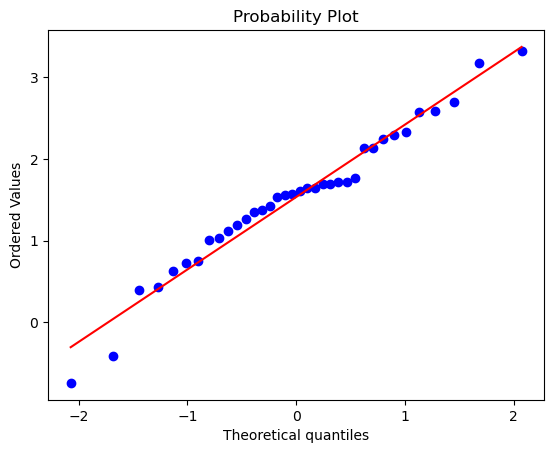

--------------------------------
p-values for all 36 data points:
0                p-value
Omnibus         0.329294
Shapiro-Wilk    0.506971
dtype: object
--------------------------------
Data are normally distributed
--------------------------------
For chanel: PSD_C2


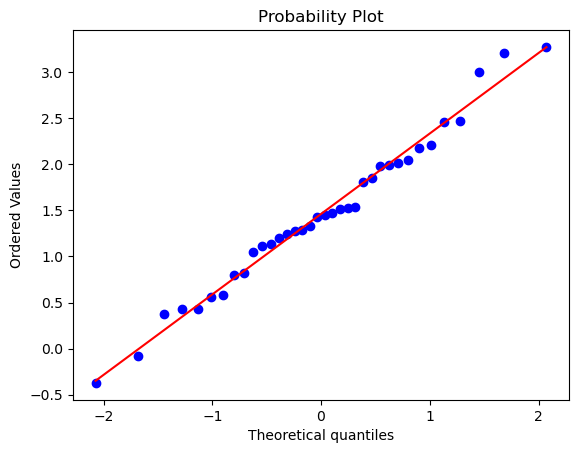

--------------------------------
p-values for all 36 data points:
0                p-value
Omnibus         0.890752
Shapiro-Wilk    0.841304
dtype: object
--------------------------------
Data are normally distributed
--------------------------------
For chanel: PSD_C4


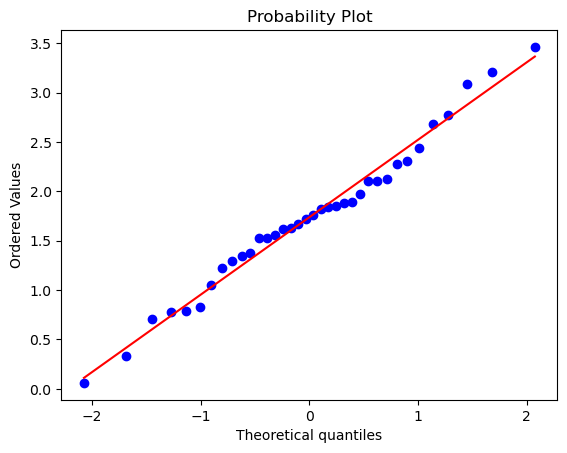

--------------------------------
p-values for all 36 data points:
0                p-value
Omnibus         0.844342
Shapiro-Wilk     0.87238
dtype: object
--------------------------------
Data are normally distributed
--------------------------------
For chanel: PSD_O1


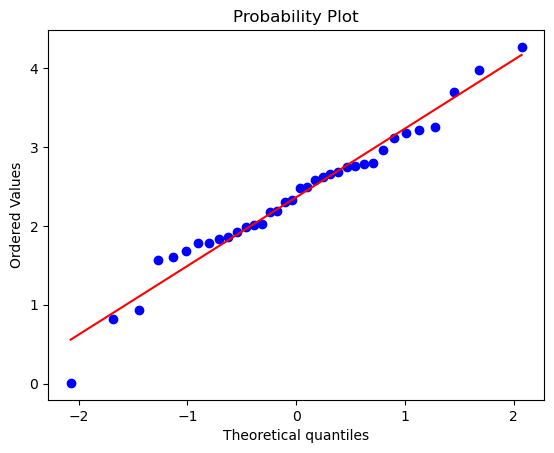

--------------------------------
p-values for all 36 data points:
0                p-value
Omnibus         0.336559
Shapiro-Wilk    0.678393
dtype: object
--------------------------------
Data are normally distributed
--------------------------------
For chanel: PSD_OZ


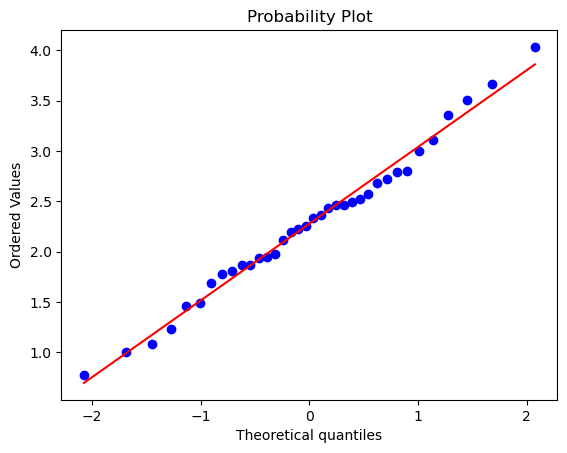

--------------------------------
p-values for all 36 data points:
0                p-value
Omnibus         0.834896
Shapiro-Wilk    0.959707
dtype: object
--------------------------------
Data are normally distributed
--------------------------------
For chanel: PSD_O2


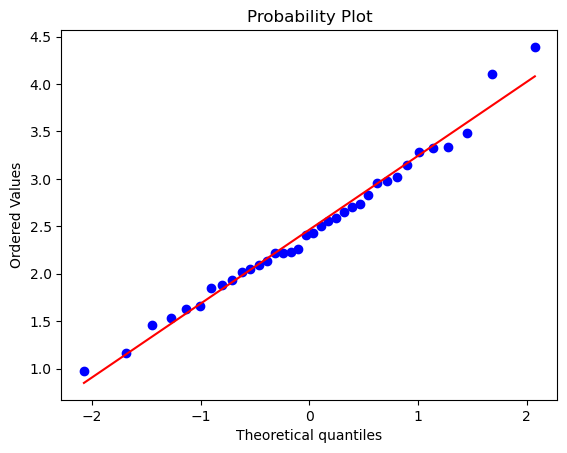

--------------------------------
p-values for all 36 data points:
0                p-value
Omnibus         0.460351
Shapiro-Wilk    0.881523
dtype: object
--------------------------------
Data are normally distributed
--------------------------------
For chanel: PSD_C3


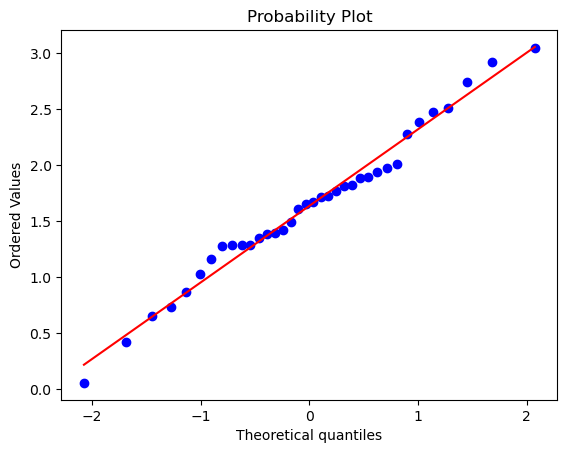

--------------------------------
p-values for all 36 data points:
0                p-value
Omnibus         0.871345
Shapiro-Wilk    0.875673
dtype: object
--------------------------------
Data are normally distributed
--------------------------------


In [122]:
names=df.columns.values
pcontrol=sum(df["Estado"]=="Control")
for i in names[1:]: #Se aplica la prueba de normalidad a cada canal de los pacientes control
    print("For chanel: "+i)
    c=df.loc[0:pcontrol-1,i]
    x=check_normality(c)

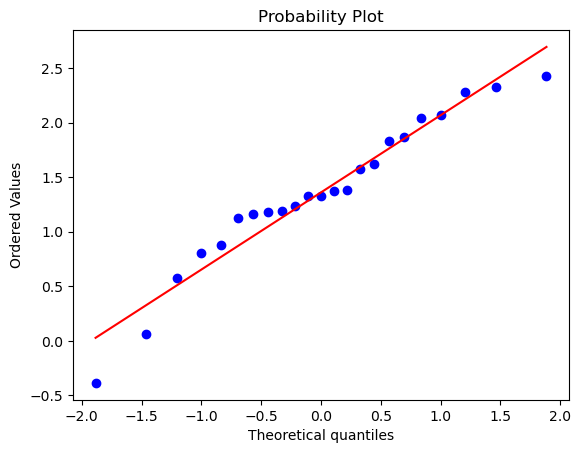

--------------------------------
p-values for all 23 data points:
0                p-value
Omnibus          0.22902
Shapiro-Wilk    0.309295
dtype: object
--------------------------------
Data are normally distributed
--------------------------------


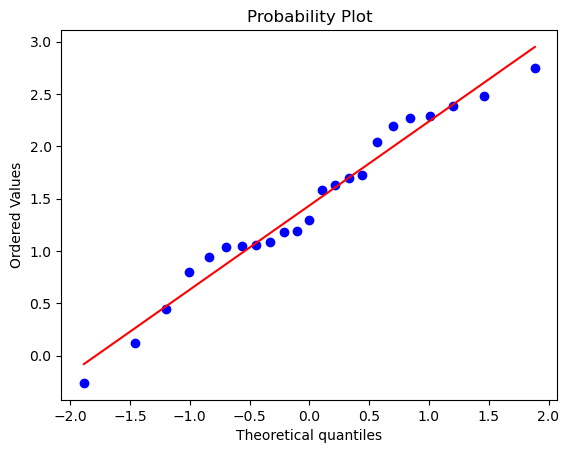

--------------------------------
p-values for all 23 data points:
0                p-value
Omnibus         0.827219
Shapiro-Wilk     0.67203
dtype: object
--------------------------------
Data are normally distributed
--------------------------------


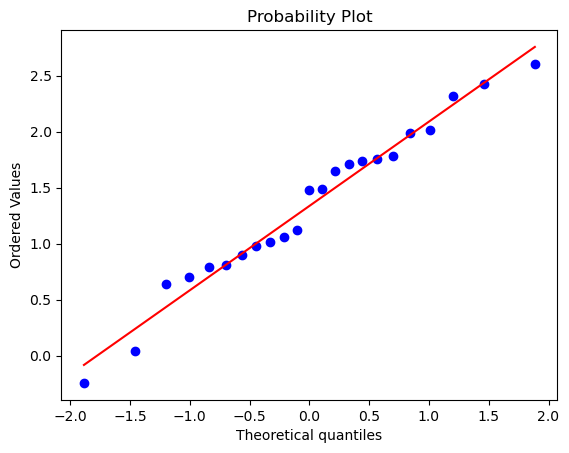

--------------------------------
p-values for all 23 data points:
0                p-value
Omnibus         0.839955
Shapiro-Wilk    0.773939
dtype: object
--------------------------------
Data are normally distributed
--------------------------------


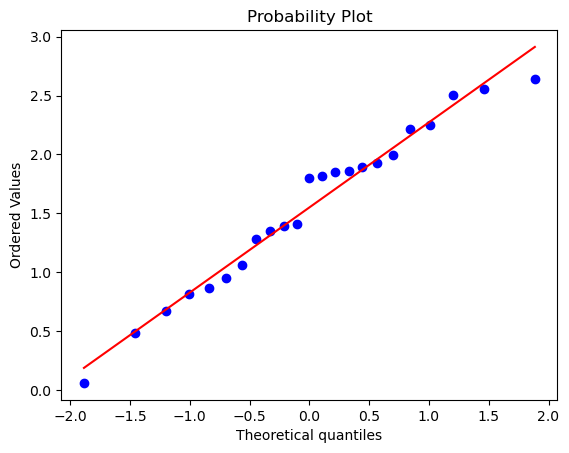

--------------------------------
p-values for all 23 data points:
0                p-value
Omnibus         0.652662
Shapiro-Wilk    0.636744
dtype: object
--------------------------------
Data are normally distributed
--------------------------------


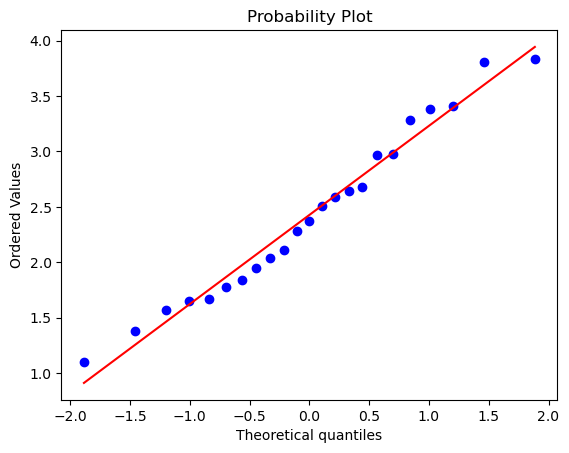

--------------------------------
p-values for all 23 data points:
0                p-value
Omnibus         0.490294
Shapiro-Wilk    0.611175
dtype: object
--------------------------------
Data are normally distributed
--------------------------------


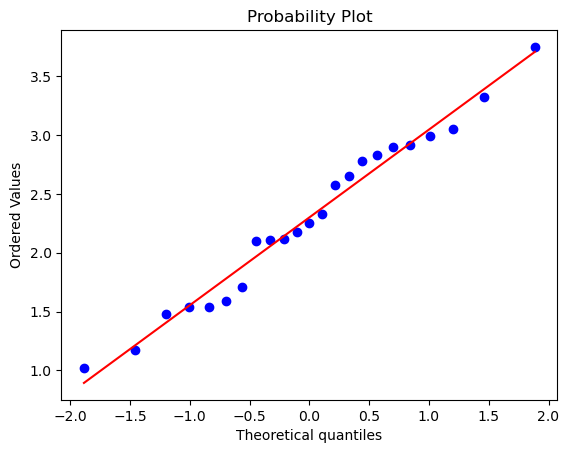

--------------------------------
p-values for all 23 data points:
0                p-value
Omnibus         0.729693
Shapiro-Wilk    0.788068
dtype: object
--------------------------------
Data are normally distributed
--------------------------------


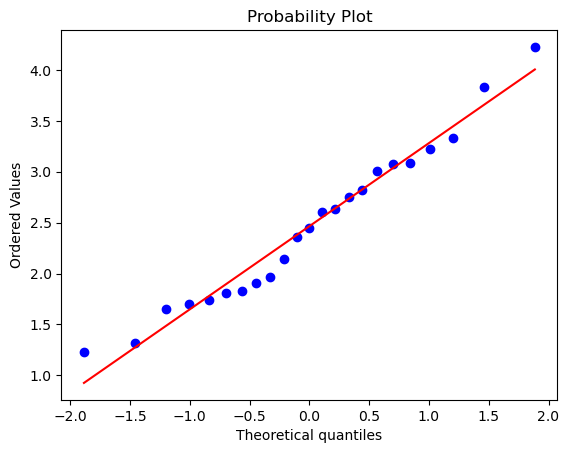

--------------------------------
p-values for all 23 data points:
0                p-value
Omnibus         0.635234
Shapiro-Wilk    0.602632
dtype: object
--------------------------------
Data are normally distributed
--------------------------------


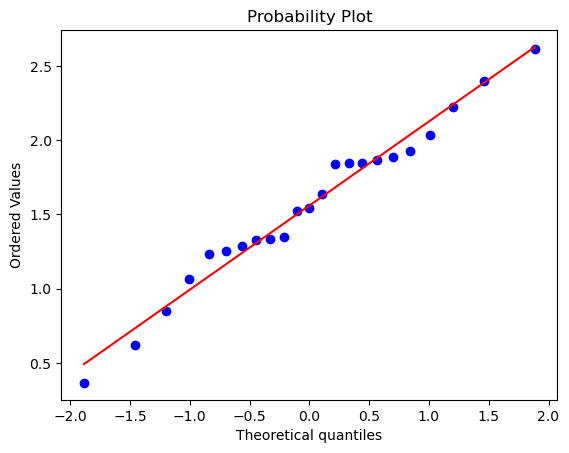

--------------------------------
p-values for all 23 data points:
0                p-value
Omnibus         0.835285
Shapiro-Wilk    0.916584
dtype: object
--------------------------------
Data are normally distributed
--------------------------------


In [93]:
for i in names[1:]: #Se aplica la prueba de normalidad a cada canal de los pacientes Parkinson
    c=df.loc[pcontrol:len(df),i]
    x=check_normality(c)

In [127]:
df.loc[0:36]

,Estado,PSD_C1,PSD_CZ,PSD_C2,PSD_C4,PSD_O1,PSD_OZ,PSD_O2,PSD_C3
0,Control,1.969944,2.138664,1.847274,1.842374,2.174078,1.982596,2.430963,1.885270
1,Control,1.543877,1.007752,0.818813,1.554001,2.587064,2.437942,2.555965,1.936895
2,Control,1.280670,1.697008,0.798658,1.715042,0.937341,1.080049,1.528186,1.390917
3,Control,1.890654,2.291016,2.461719,2.681742,3.119428,2.718425,2.501808,2.278506
4,Control,1.906328,2.134594,2.177472,2.124746,2.334029,2.254467,2.260690,1.669424
5,Control,1.698380,1.573914,1.116531,1.297752,1.605561,1.688745,1.879888,1.822043
6,Control,1.076733,1.345942,1.450012,1.615877,2.020466,1.871742,2.220056,1.420648
7,Control,1.017888,1.031970,1.050074,1.756193,1.926415,1.935559,2.229193,1.289169
8,Control,0.714011,0.728458,0.433712,0.330808,2.486861,2.193074,2.088275,0.655957
9,Control,1.986338,1.761787,1.327057,1.526609,2.619216,2.799719,2.951347,1.889735


In [133]:
#VERIFICANDO HOMOSEDASTICIDAD
con=0
for i in names[1:]:
  c=df.loc[0:pcontrol-1,i]
  p=df.loc[pcontrol:len(df),i]
  p_valor = levene(c, p).pvalue
  print("Canal %s p=%.3f "% (names[con],p_valor))
  con+=1
  if p_valor > 0.05:
    print("Los datos son homocedásticos.")
  else:
    print("Los datos no son homocedásticos.")

Canal Estado p=0.381 
Los datos son homocedásticos.
Canal PSD_C1 p=0.729 
Los datos son homocedásticos.
Canal PSD_CZ p=0.417 
Los datos son homocedásticos.
Canal PSD_C2 p=0.678 
Los datos son homocedásticos.
Canal PSD_C4 p=0.936 
Los datos son homocedásticos.
Canal PSD_O1 p=0.731 
Los datos son homocedásticos.
Canal PSD_OZ p=0.614 
Los datos son homocedásticos.
Canal PSD_O2 p=0.293 
Los datos son homocedásticos.


In [138]:
dataframes = [df[df['Estado']=='Control'], df[df['Estado']=='Parkinson']]

In [144]:
df,dfp=dataframes[0],dataframes[1]

In [147]:
con=0
for i in names[1:]:
  c=df.loc[:,i]
  p=dfp.loc[:,i] 
  print("Canal:%s"%names[con])
  con+=1
  t=pg.ttest(x=c, y=p, alternative='two-sided', correction=False)
  p=t.loc["T-test","p-val"]
  alpha=0.05
  if p > alpha:
        print('Same distribution (fail to reject H0)')
  else:
        print('Different distribution (reject H0)')
  display(t)

Canal:Estado
Same distribution (fail to reject H0)


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.085233,56,two-sided,0.93238,"[-0.34, 0.37]",0.023065,0.274,0.050804


Canal:PSD_C1
Same distribution (fail to reject H0)


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.100595,56,two-sided,0.920232,"[-0.42, 0.46]",0.027222,0.274,0.051121


Canal:PSD_CZ
Same distribution (fail to reject H0)


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.248774,56,two-sided,0.804445,"[-0.37, 0.48]",0.067322,0.28,0.056878


Canal:PSD_C2
Same distribution (fail to reject H0)


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.621721,56,two-sided,0.536648,"[-0.27, 0.51]",0.168247,0.32,0.093763


Canal:PSD_C4
Same distribution (fail to reject H0)


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.419835,56,two-sided,0.676213,"[-0.54, 0.35]",0.113613,0.293,0.069728


Canal:PSD_O1
Same distribution (fail to reject H0)


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.138298,56,two-sided,0.890501,"[-0.43, 0.37]",0.037425,0.275,0.05212


Canal:PSD_OZ
Same distribution (fail to reject H0)


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.121967,56,two-sided,0.903361,"[-0.45, 0.39]",0.033006,0.274,0.051648


Canal:PSD_O2
Same distribution (fail to reject H0)


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.132672,56,two-sided,0.894929,"[-0.31, 0.35]",0.035903,0.275,0.051951
